# Building your own Object Detector from scratch

This notebook has educational purposes only.

It shows how to build a simple Object Detector from scratch using Tensorflow & Keras.

The model is trained over the Labeled Mask database.

Check this story on medium for more details: https://medium.com/@doleron/building-your-own-object-detector-from-scratch-bfeadfaddad8

## Getting the data

Before run this notebook, it is necessary to download the archive file with the training images and respective annotation files.

The file is available on Kaggle: https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet

Hit the download button and copy the `archive.zip` to the `data` folder. After that, run the next cell.

The previous cell uncompress the `archive.zip` file and store the images & text files in the `data/obj` folder. We can inspect the contents of those files as shown below:  

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techzizou/labeled-mask-dataset-yolo-darknet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'labeled-mask-dataset-yolo-darknet' dataset.
Path to dataset files: /kaggle/input/labeled-mask-dataset-yolo-darknet


In [ ]:
!ls {path}/obj

 0.jpg		     'masked (1353).txt'    'unmasked (1381).jpg'
 0.txt		     'masked (1354).jpg'    'unmasked (1381).txt'
 0-with-mask.jpg     'masked (1354).txt'    'unmasked (1382).jpg'
 0-with-mask.txt     'masked (1355).jpg'    'unmasked (1382).txt'
 100-with-mask.jpg   'masked (1355).txt'    'unmasked (1383).jpg'
 100-with-mask.txt   'masked (1356).jpg'    'unmasked (1383).txt'
 101-with-mask.jpg   'masked (1356).txt'    'unmasked (1384).jpg'
 101-with-mask.txt   'masked (1357).jpg'    'unmasked (1384).txt'
 103-with-mask.jpg   'masked (1357).txt'    'unmasked (1385).jpg'
 103-with-mask.txt   'masked (1358).jpg'    'unmasked (1385).txt'
 104-with-mask.jpg   'masked (1358).txt'    'unmasked (1386).jpg'
 104-with-mask.txt   'masked (1359).jpg'    'unmasked (1386).txt'
 105-with-mask.jpg   'masked (1359).txt'    'unmasked (1387).jpg'
 105-with-mask.txt   'masked (1360).jpg'    'unmasked (1387).txt'
 106-with-mask.jpg   'masked (1360).txt'    'unmasked (1388).jpg'
 106-with-mask.txt   'mask

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import shutil

In [ ]:
data_dir = pathlib.Path(path + "/obj/").with_suffix('')
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


/kaggle/input/labeled-mask-dataset-yolo-darknet/obj/374-with-mask.jpg


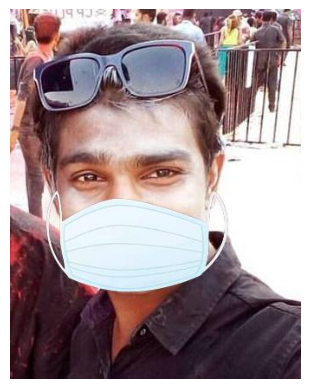

In [ ]:
sample_img_path = str(image_files[115])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Basically, the data consist of images files and respective annotation files. Each annotation file has one or more lines in which we can find the class and bounding box coordinates:

In [ ]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.4226190476190476 0.5351288056206089 0.5654761904761905 0.49882903981264637\n']


The following function filter the files, generating 3 lists:

- training files (70% of images)
- validation files (20% of images)
- test files (last 10%)

In [ ]:
import os, random

def list_files(full_data_path = f"{path}/obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue


                strip = file[0:len(file) - len(".txt")]
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]

In [ ]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


This is actually a small dataset. We have only 904 images to train our model!

Let's combine image and annotations in order to check if we actually understand how to deal with the data.

In addition, let's format the images for the input size of our model (244 x 244)

In [ ]:
input_size = 244

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

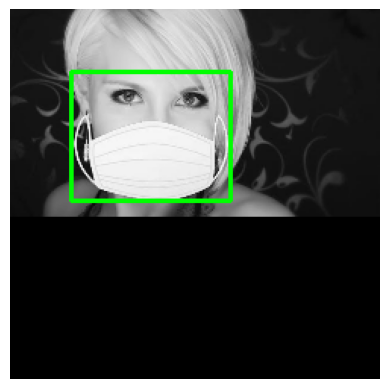

In [ ]:
temp_img = cv.imread(f"{path}/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

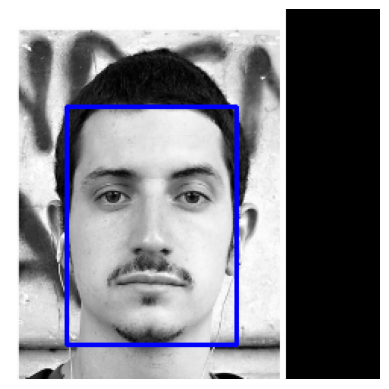

In [ ]:
temp_img = cv.imread(f"{path}/obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

The dataset is composed by different images of peoplse using or not masks. Let's create a tensorflow dataset with the images:

In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
def data_load(files, full_data_path = f"{path}/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)

        # Explicitly resize image to input_size x input_size after padding
        img = cv.resize(img, (input_size, input_size), interpolation=cv.INTER_LINEAR)


        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [ ]:
raw_train_ds = data_load(training_files)

In [ ]:
raw_validation_ds = data_load(validation_files)

In [ ]:
raw_test_ds = data_load(test_files)

The training, validation & test datasets must be set up in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [ ]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [ ]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_ds = tune_training_ds(raw_train_ds)

In [ ]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [ ]:
validation_ds = tune_validation_ds(raw_validation_ds)

Let's inspect our training dataset:

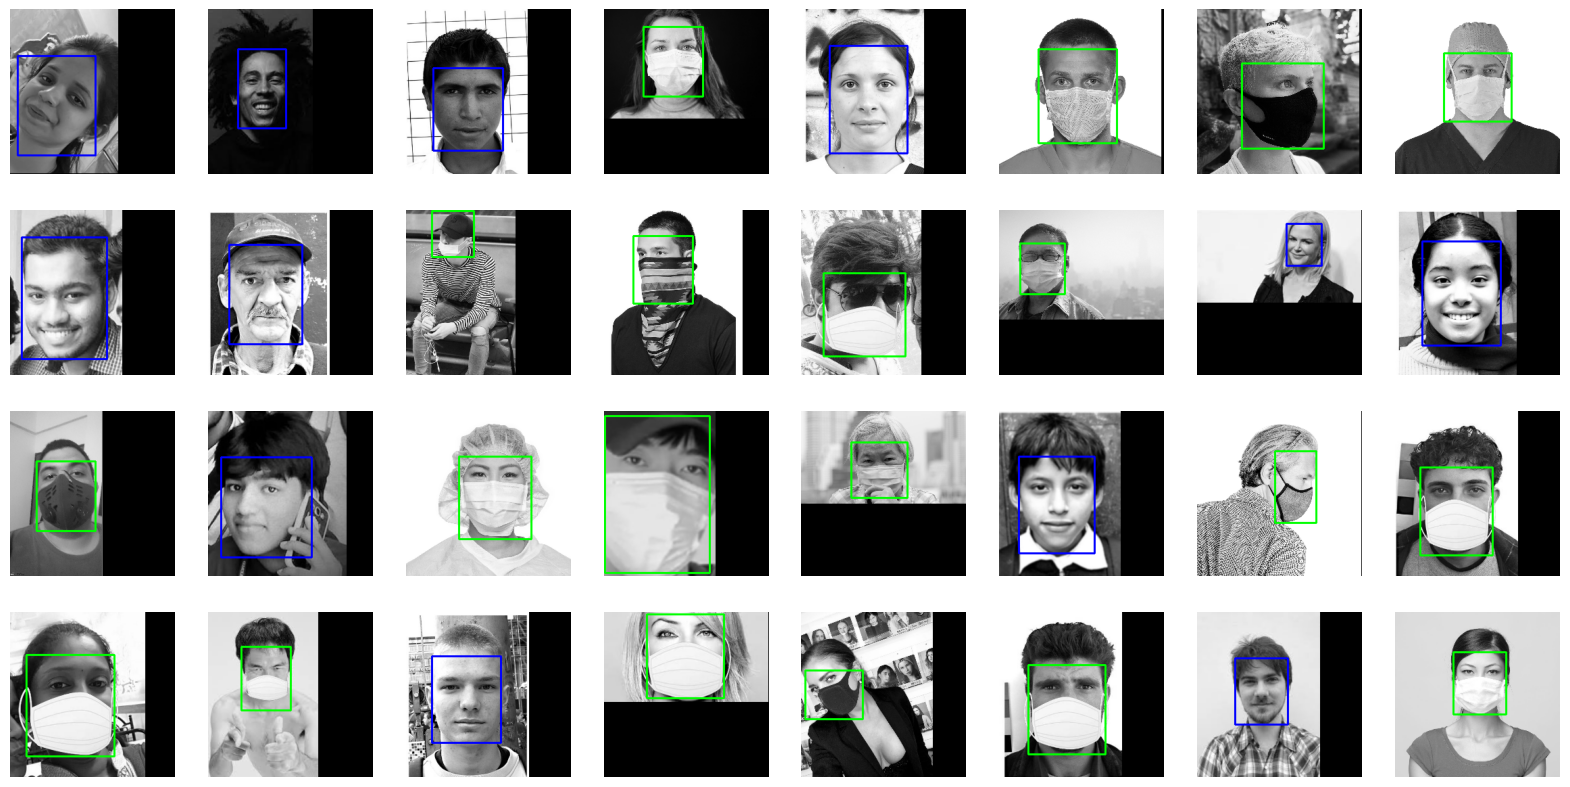

In [ ]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Based on the image above, we can realize that the training dataset is correctly set. Blue rectangles represent bounding box of **unmask people**. A green rectangle represent a masked person.

Once the data is ready, we can start our modelling and training.

## The model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Funcional API, as follows:

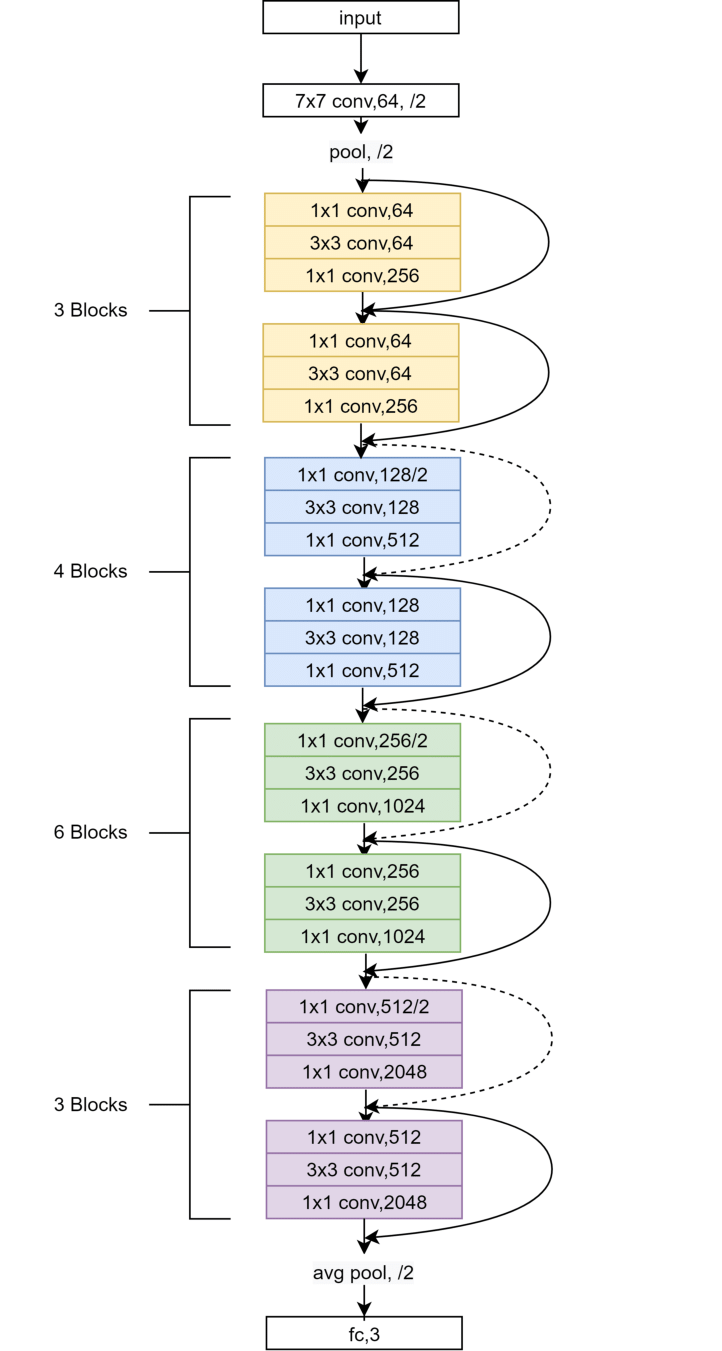

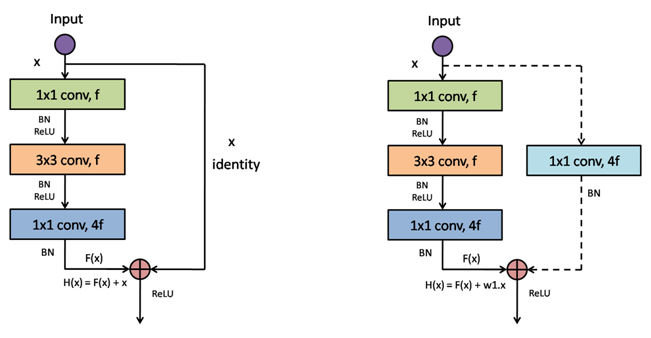

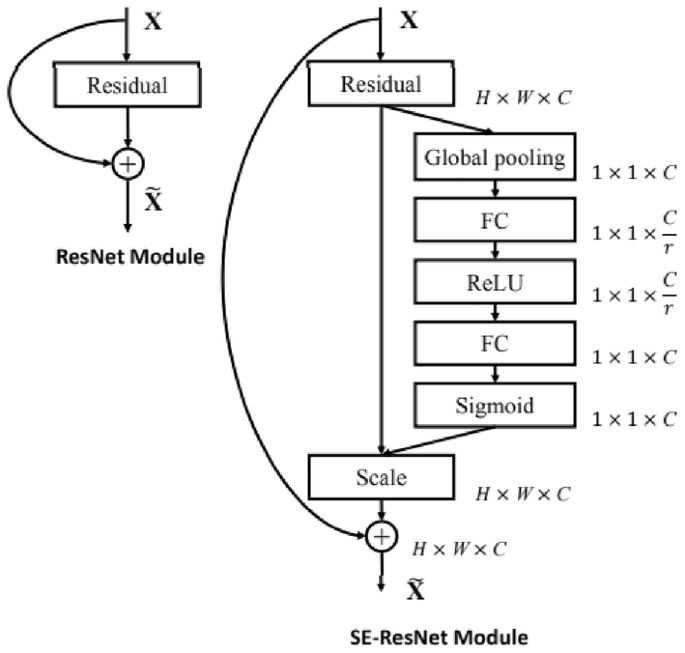

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model

In [ ]:
def se_block(input_tensor, ratio=16):
    """
    Crea un bloque Squeeze-and-Excitation.
    """
    init_filters = input_tensor.shape[-1]
    se_shape = (1, 1, init_filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(init_filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(init_filters, activation='sigmoid', use_bias=False)(se)

    output_tensor = Multiply()([input_tensor, se])
    return output_tensor

In [ ]:
# --- 2. El Bloque Cuello de Botella MODIFICADO con SE ---
def bloque_residual_bottleneck(x, filtros_internos, stage_filters, stride=1, es_atajo_convolucional=False):
    """
    Un bloque residual con arquitectura de cuello de botella Y un bloque SE integrado.
    """
    F1, F2, F3 = filtros_internos
    x_atajo = x

    # Primera 1x1 CONV
    x = Conv2D(F1, kernel_size=1, strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Segunda 3x3 CONV
    x = Conv2D(F2, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Tercera 1x1 CONV
    x = Conv2D(F3, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Bloque SE - Attention
    x = se_block(x)

    ##### ATADO (SKIP CONNECTION) #####
    if es_atajo_convolucional:
        x_atajo = Conv2D(stage_filters, kernel_size=1, strides=stride, padding='valid')(x_atajo)
        x_atajo = BatchNormalization()(x_atajo)

    # Sumamos la salida del camino principal (ya recalibrada por SE) con la del atajo
    x = Add()([x, x_atajo])
    x = Activation('relu')(x)

    return x

In [ ]:
def crear_resnet50(inputs):
    """
    Construye el modelo ResNet-50 completo.
    """

    # Etapa 1 (conv1)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', name='conv1_pad')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    # Etapa 2 (conv2_x) - 3 bloques de cuello de botella
    # Primer bloque: stride=1, el atajo es convolucional para cambiar de 64 a 256 filtros
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=False) # Los siguientes son bloques identidad
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=False)

    # Etapa 3 (conv3_x) - 4 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 256 a 512 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)

    # Etapa 4 (conv4_x) - 6 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 512 a 1024 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)

    # Etapa 5 (conv5_x) - 3 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 1024 a 2048 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=1, es_atajo_convolucional=False)

    # Capas finales
    x = GlobalAveragePooling2D(name='avg_pool')(x) # Se usa mejor GlobalAveragePooling2D porque la entrada de las imagenes son de 244x244

    # Creamos el modelo final
    return x

In [ ]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    return crear_resnet50(inputs)

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

It is notewhortly that each network head has a specific set of loss function and metrics:

In [ ]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad (Conv2D)  │ (None, 122, 122,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 122, 122,  │        256 │ conv1_pad[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 122, 122,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 61, 61,    │          0 │ conv1_relu[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 61,    │      4,160 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 61, 61,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     16,640 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 256) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 16)  │      4,096 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 256) │      4,096 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │     16,640 │ pool1[0][0]     

 Total params: 26,227,910 (100.05 MB)

 Trainable params: 26,174,790 (99.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model training

Our model is all set and we can start the training, as shown in the next cell:

In [ ]:
EPOCHS = 100

model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1,)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 645ms/step - classifier_head_accuracy: 0.5970 - classifier_head_loss: 0.7289 - loss: 1.6486 - regressor_head_loss: 0.9197 - regressor_head_mse: 0.9197 - val_classifier_head_accuracy: 0.5000 - val_classifier_head_loss: 0.6940 - val_loss: 0.7467 - val_regressor_head_loss: 0.0527 - val_regressor_head_mse: 0.0527
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - classifier_head_accuracy: 0.8286 - classifier_head_loss: 0.4786 - loss: 0.5121 - regressor_head_loss: 0.0335 - regressor_head_mse: 0.0335 - val_classifier_head_accuracy: 0.5000 - val_classifier_head_loss: 0.6988 - val_loss: 0.7213 - val_regressor_head_loss: 0.0224 - val_regressor_head_mse: 0.0224
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - classifier_head_accuracy: 0.8002 - classifier_head_loss: 0.4868 - loss: 0.5198 - regressor_head_loss: 0.0330 - regressor_head_mse: 0.0330 - val_classifier_head_accuracy: 0.5000 - val_classifier_head_loss: 0.7009 - val_loss: 0.7275 - val_reg

The training performance can be checked in the charts below.

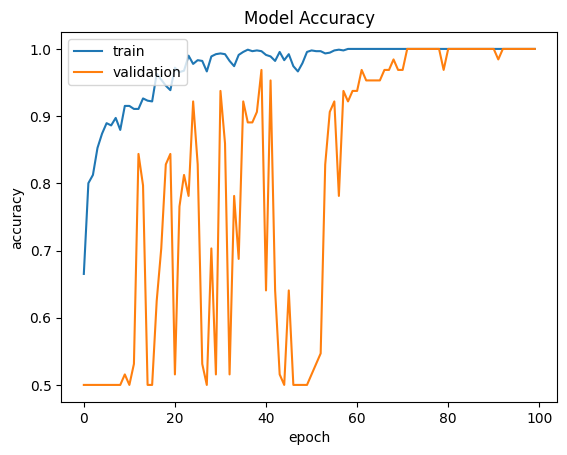

In [ ]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Conclusions**

* Train acc = 1.00 from approximately epoch 40 onward, indicating potential overfitting; validation does not drop.
* Val acc is unstable at the beginning, rising and falling sharply until epochs 30–40. Typical validation signal is small, with a strong data spike or high LR.
* From epoch 60 onward, it stabilizes at 0.93–0.95, describing very good final performance.
* Validation is noisy at the beginning, but later reaches the same accuracy as with the training data.

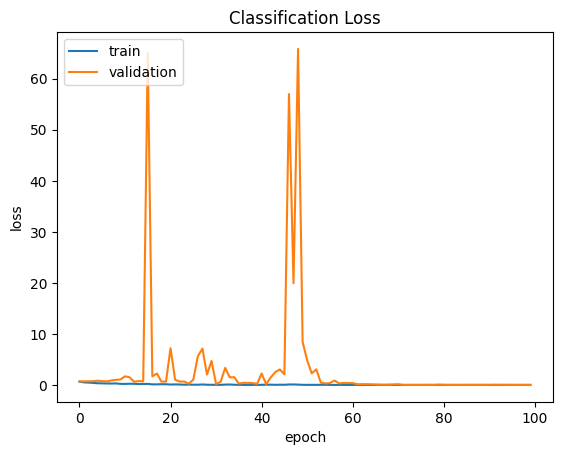

In [ ]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Conclusions**

* Train loss drops smoothly to ~0 and remains very low, meaning the model learns the train very well (risk of overfitting).
* Val loss: hypervolatile between epochs 1–45 with peaks of up to 6, then drops sharply and from epochs 55–65 it remains stable around 0.25–0.35.
* Validation was unstable at first, but the model eventually stabilizes and generalizes.

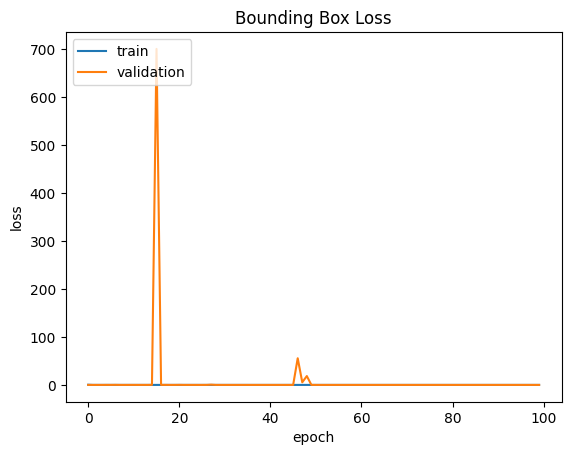

In [ ]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Conclusions**

* The Train Loss drops very rapidly in the first 2–3 epochs, going from 0.6 to 0.05, and then remaining almost at 0.
* The Val loss starts at approximately 0.20–0.25, with slight peaks in the first 40 epochs, but then stabilizes very low (0.01–0.02) in the final epochs.
* Both train and val converge to very low values, demonstrating an excellent fit for the regression task (bounding boxes), with no signs of strong overfitting or divergence.
* The regressor head is very stable and does not exhibit the same instability as the classifier. The model learned the box coordinates well, and the gap between train and val is minimal, indicating that it generalizes well in this area.

## Evaluation

The best way to evaluate the end model performance is by using IoU - intersection over Union - metrics. The following implementation of IoU was adapted from PyImage Search website:

In [ ]:
test_ds_eval = raw_test_ds.map(format_instance).batch(len(test_files))
test_results = model.evaluate(test_ds_eval)
print(test_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - classifier_head_accuracy: 0.9462 - classifier_head_loss: 0.3589 - loss: 0.3664 - regressor_head_loss: 0.0074 - regressor_head_mse: 0.0074
[0.36638709902763367, 0.358948677778244, 0.007438428699970245, 0.9461538195610046, 0.007438428699970245]


In [ ]:
test_accuracy = test_results[3]
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9461538195610046


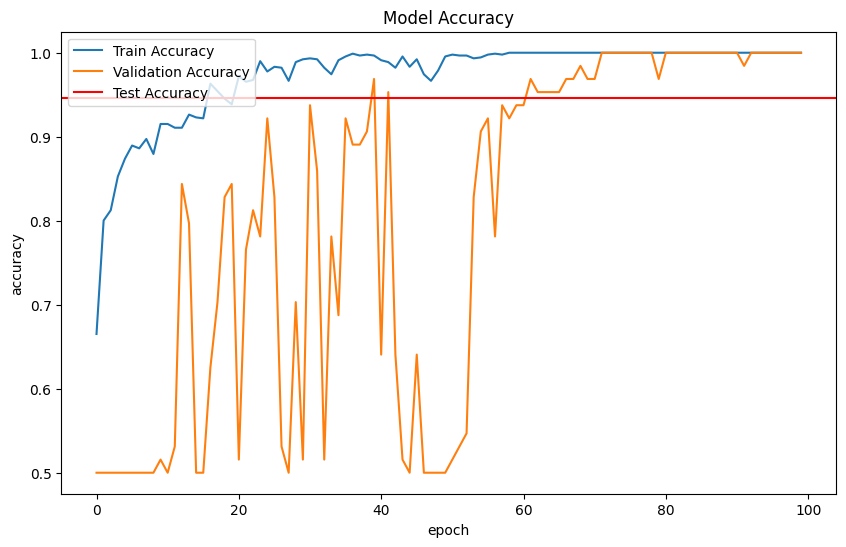

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['classifier_head_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classifier_head_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### **Conclusions**

* Generalization is good. The fact that the val acc and test acc are consistent (approximately 0.93–0.94) indicates that the model generalizes, and there is no significant overfitting gap at the end.
* Initial training was somewhat noisy; validation oscillations in the early epochs suggest that the validation set is small or unstratified. The learning rate was initially high, or data augmentation was strong. However, the model managed to stabilize, and testing confirmed robustness by maintaining the test set. Therefore, we can trust the model.

In [ ]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [ ]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

The model performance is finally evaluated on the test dataset. Green boxes indicaates correct classification in which the predicted label (masked-unmasked) matches with the actual label.
A red box indicate a wrong classification.

30


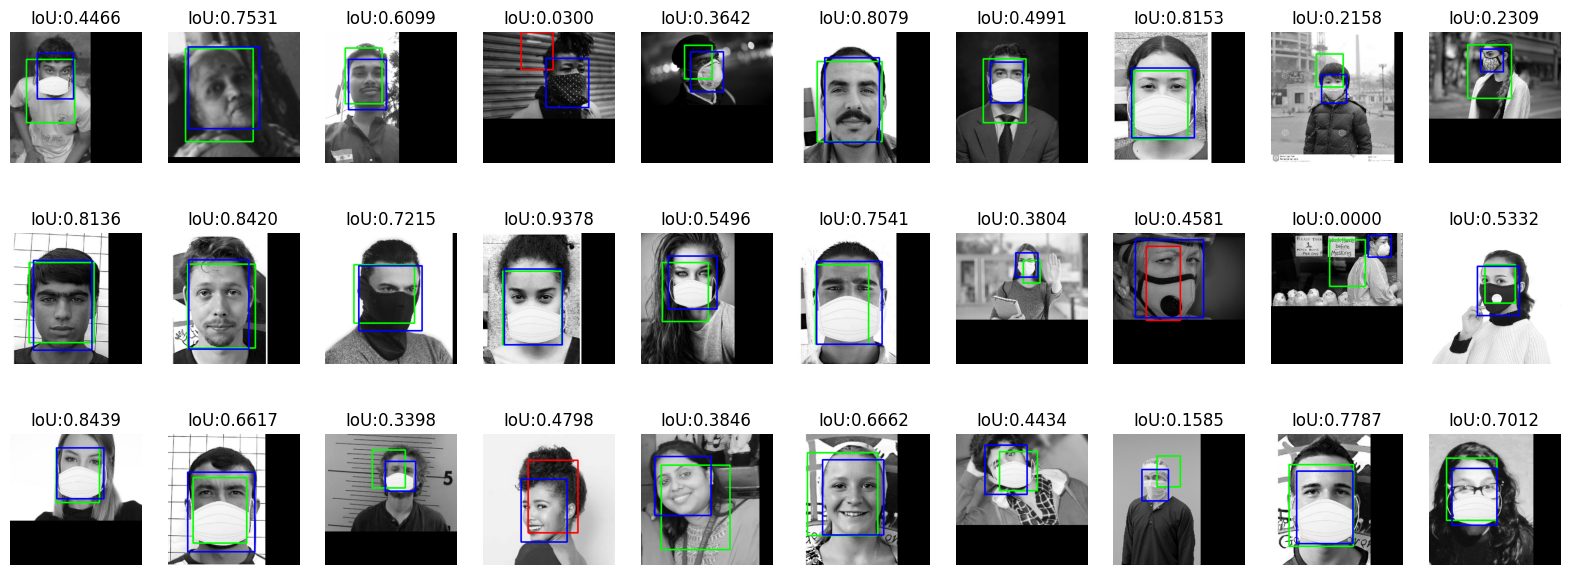

In [ ]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(30).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## **Grad-CAM class activation visualization**
The Grad-CAM algorithm is a technique that produces a visual "heatmap" to show what parts of an image a Convolutional Neural Network (CNN) is focusing on to make a decision. It's an interpretability tool that helps us understand the "why" behind a prediction.

In essence, Grad-CAM (Gradient-weighted Class Activation Mapping) allows you to see which regions of an input image were most important for the model to classify it with a specific label

The Grad-CAM algorithm

References:
- https://keras.io/examples/vision/grad_cam/
- https://www.pinecone.io/learn/class-activation-maps/

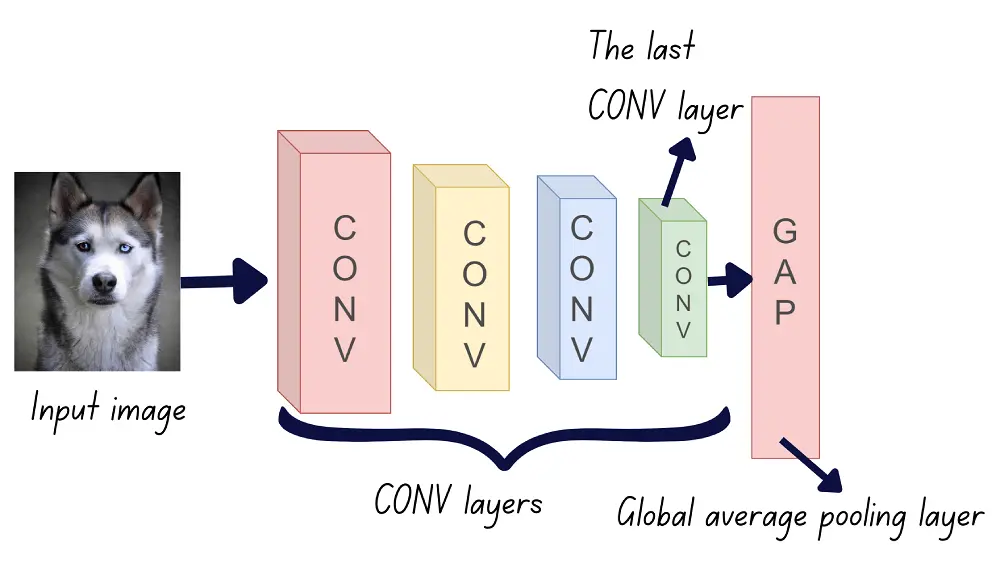

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_last_conv_layer(model):
    conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
    if not conv_layers:
        raise ValueError("Layer not found")
    return conv_layers[-2]

def make_gradcam_heatmap(img_batch, model, classifier_layer_name='classifier_head', pred_index=None):
    """
    img_batch: tensor con forma (1, H, W, C)
    """
    last_conv = get_last_conv_layer(model)

    grad_model = tf.keras.Model(
        [model.inputs],
        [last_conv.output, model.get_layer(classifier_layer_name).output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds_cls = grad_model(img_batch)
        if pred_index is None:
            pred_index = tf.argmax(preds_cls[0])
        class_channel = preds_cls[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]  # (Hc, Wc, C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.45):
    """
    img: (H, W, 1) o (H, W, 3) en rango 0..255 o 0..1
    Devuelve imagen superpuesta en RGB uint8.
    """
    img_np = np.array(img)
    if img_np.max() <= 1.0:
        img_np = (img_np * 255.0).astype(np.uint8)
    else:
        img_np = img_np.astype(np.uint8)

    if img_np.ndim == 2:
        img_np = np.expand_dims(img_np, -1)
    if img_np.shape[-1] == 1:
        img_rgb = np.repeat(img_np, 3, axis=-1)
    else:
        img_rgb = img_np

    H, W = img_rgb.shape[:2]
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)  # BGR
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_color = cv2.resize(heatmap_color, (W, H), interpolation=cv2.INTER_LINEAR)

    overlay = cv2.addWeighted(heatmap_color, alpha, img_rgb, 1 - alpha, 0)
    return overlay

def draw_bbox(img_rgb, box_xywh, color=(0, 255, 0), thickness=2):
    """
    box_xywh: [x, y, w, h] en coordenadas relativas (0..1) al tamaño de la imagen
    """
    H, W = img_rgb.shape[:2]
    x, y, w, h = box_xywh
    x1 = int(x * W); y1 = int(y * H)
    x2 = int((x + w) * W); y2 = int((y + h) * H)
    out = img_rgb.copy()
    cv2.rectangle(out, (x1, y1), (x2, y2), color, thickness)
    return out


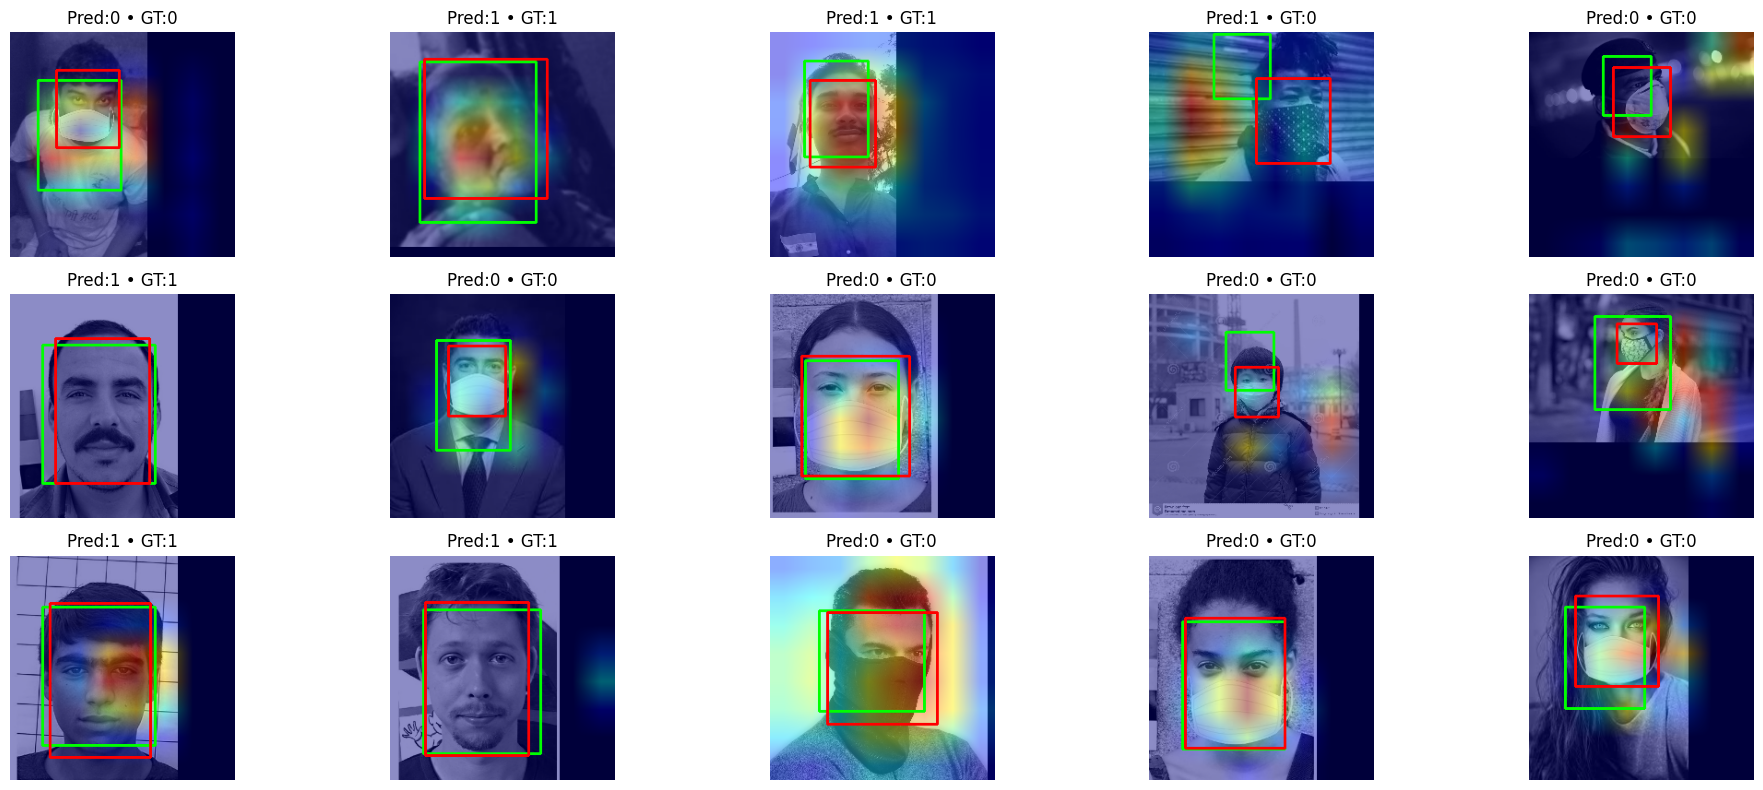

In [ ]:
plt.figure(figsize=(20,8))

test_samples = list(test_ds.take(15).as_numpy_iterator())


for i, (img_batch, (labels_onehot_b, bboxes_b)) in enumerate(test_samples):

  img = img_batch[0]
  true_onehot = labels_onehot_b[0]
  true_box = bboxes_b[0]

  pred_cls_b, pred_box_b = model.predict(img_batch, verbose=0)
  pred_cls = pred_cls_b[0]         # (CLASSES,)
  pred_box = pred_box_b[0]         # (4,)

  pred_class_idx = int(np.argmax(pred_cls))
  true_class_idx = int(np.argmax(true_onehot))

  # Grad-CAM heatmap
  heatmap = make_gradcam_heatmap(img_batch, model, classifier_layer_name='classifier_head', pred_index=pred_class_idx)

  # Prepare visualizations
  img0 = img.numpy() if isinstance(img, tf.Tensor) else img
  overlay = overlay_heatmap_on_image(img0, heatmap, alpha=0.45)

  # Draw boxes: predicted (green) and true (red)
  vis_pred = draw_bbox(overlay, pred_box, color=(0, 255, 0), thickness=2)
  vis_both = draw_bbox(vis_pred, true_box, color=(255, 0, 0), thickness=2)

  pos = (i+1)

  plt.subplot(3, 5, pos)
  plt.title(f"Pred:{pred_class_idx} • GT:{true_class_idx}")
  plt.imshow(vis_both)
  plt.axis("off")

plt.tight_layout()
plt.show()

### **Conclusions**

Based on the Grad-CAM visualizations, we can see that the model primarily focuses on the facial region of the images when making its predictions. The heat maps show the areas that most influence the model's decision, and these areas consistently align with the location of the person's face, whether masked or unmasked. This indicates that the model effectively uses relevant visual information to classify the images and predict bounding boxes.